# Aula 4 - otimização bayesiana

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Introdução
- 2) Otimização bayesiana
- 3) Ferramentas de visualização da skopt

Na parte prática da aula de hoje, usaremos a biblioteca [scikit-optimize](https://scikit-optimize.github.io/stable/).

Para instalá-la, o de sempre:

`pip install scikit-optimize`

__________

In [1]:
from ml_utils import *

____
____
_____

## 1) Introdução

Desde que conhecemos os primeiros estimadores utilizados para a construção de modelos, uma preocupação adicional nos acompanhou: o ajuste de valores dos hiperparâmetros.

Quase todos os estimadores que conhecemos têm um ou mais **hiperparâmetros** associados.

Como vimos, os hiperparâmetros influenciam o comportamento do modelo (e, portanto, são muito importantes), mas eles não são determinados a partir dos dados! É nosso dever, como cientistas de dados, fornecer valores adequados para os hiperparâmetros.

No começo de nossa jornada, nós utilizávamos os valores default para os hiperparâmetros, ou então, mudávamos manualmente alguns valores, para sensibilizar a influência dos hiperparâmetros no modelo final.

Mas logo percebemos que essa não era a melhor abordagem --- precisávamos de um método mais sistemàtico para a busca de bons valores para os hiperparâmetros!

_______

Para este fim, introduzimos inicialmente o **grid search**, que **testa exaustivamente** combinações explícitas de valores de hiperparâmetros.

Apesar de simples e direta, esta é uma abordagem computacionalmente muito custosa (sentimos isso na pele, ao rodar rotinas de grid search que demoram horas, ou até mesmo dias!). 

De fato, esta é uma abordagem de força bruta que, aliás, não nos dá garantia nenhuma: é perfeitamente possível que nenhuma das combinações que estabelecemos seja boa boa! Oras, há muitos casos em que o **espaço de hiperparâmetros** é infinito (basta considerar um hiperparâmetro dado por um float que não é limitado).

<img src=https://s3-sa-east-1.amazonaws.com/lcpi/4ad728dc-ab11-46a7-957a-003b1034099b.gif width=400>

______

Para endereçar este problema, introduzimos então o **random search**.

Neste caso, ao invés de disponibilizarmos valores específicos de hiperparâmetros a serem combinados, disponibilizamos **intervalos** ou explicitamente **distribuições de probabilidade** sobre o espaço de parâmetros de cada hiperparâmetro, e **amostramos valores aleatórios** destas distribuições para gerar as combinações.

Com essa abordagem estocástica, há a possibilidade de encontrarmos boas combinações, que não estariam inclusas nos valores explícitos que passamos para o grid search.

Por outro lado, com o random search também não temos garantia alguma que as melhores combinações serão encontradas, sobretudo porque **todas as combinações são amostradas de maneira aleatória**. Ou seja, todas as combinações são amostradas **sem considerar** a performance das combinações anteriores. Com esta metodologia, fica difícil garantirmos que efetivamente encontraremos boas combinações...

<img src=https://s3-sa-east-1.amazonaws.com/lcpi/00bcaf02-32e8-46ca-8bf3-8f1db62dbcf2.gif width=400>

Metodologia de grid search (à esquerda) vs random search (à direita):

<img src=https://www.researchgate.net/profile/Minrui-Zheng/publication/328252103/figure/fig4/AS:766093471801344@1559662325592/Distribution-of-sampled-hyperparameters-a-grid-search-b-random-search.png width=600>

_________

Então, podemos nos perguntar: qual seria o próximo passo? Existiria um método ainda mais eficiente e "educado" para fazer a otimização de hiperparâmetros?

Será que não existe alguma forma de buscarmos por hiperparâmetros de maneira estocástica, mas que ao mesmo tempo nos possibilite algum direcionamento para que tenhamos mais chances de encontrar boas combinações no espaço de hiperparâmetros? Algo assim:

<img src=https://s3-sa-east-1.amazonaws.com/lcpi/d7b84011-d606-4a05-8a49-3d692071b4f5.gif width=400>

A resposta é: sim! Hoje, conheceremos o método de **otimização Bayesiana**, aplicada à otimização de hiperparâmetros, cujo objetivo é exatamente este!

> importante: como veremos, a principal vantagem da otimização Bayesiana é conseguirmos bons conjuntos de hiperparâmetros com **poucas buscas**, isto é, em poucos ciclos de treinamento e validação. Isso é muito bom, sobretudo em casos em que é muito custoso (financeiramente ou em tempo) rodar os testes de parâmetros várias vezes --- em alguns casos, rodar o modelo uma única vez para apenas um conjunto de hiperparâmetros pode demorar horas e, dessa forma, é inviável realizarmos uma busca de parâmetros com grid ou random search (com muitas iterações), o que pode ser necessário para encontrarmos um bom conjunto de hiperparâmetros. São em situações como essa que a otimização Bayesiana pode ser muitíssimo útil!

_________
_________
_________

## 2) Otimização Bayesiana

O objetivo da otimização baeysiana é o mesmo que tínhamos com o grid e random search: **determinar os valores adequados para um conjunto de hiperparâmetros**, de modo que a combinação de valores **proporcione os melhores valores para uma métrica de avaliação calculada em dados de validação**.

O que muda com a otimização baeysiana é a forma como isso será feito.

Já descrevemos os problemas que ambos grid e random search têm. Sobretudo, o fato das combinações de valores dos hiperparâmetros serem independentes entre si, sem levar em consideração combinações anteriores, que poderiam ser boas.

>Pra entender isso melhor, imagine o cenário em que queremos otimizar 3 hiperparâmetros.
<br><br>
>Pode ser que, em uma combinação, encontremos bons valores para 2 dos 3 hiperparâmetros; ja, na próxima, como os 3 valores serão novos, pode ser que os 3 sejam ruins. Não seria interessante de conseguíssemos manter a informação sobre os valores bons que encontramos?

Esse é o espírito da otimização baeysiana!

Pra entender isso intuitivamente, considere a figura a seguir (suponha que o "score" é um erro, então, quanto menor, melhor):

<img src=https://miro.medium.com/max/1120/1*MiNXGrkk5BbjfkNAXZQSNA.png width=400>

Pergunta: onde você concentraria a busca por valores do hiperparâmetro `n_estimators`?

Olhando pro gráfico, existe claramente uma região no espaço do hiperparâmetro `n_estimators` que é melhor: menos de 200 árvores.

**Uma vez que temos este conhecimento**, realmente não faz sentido algum que os próximos valores que vamos testar sejam maiores que 200, não é mesmo?

Esse é o espírito da otimização bayesiana: **utilizamos a informação que temos quanto ao score alcançado com valores iniciais de hiperparâmetros para guiar a escolha dos próximos valores!**

E aqui já fica claro o porquê do método receber o título "bayesiano": de fato, estamos nos utilizando da "filosofia" bayesiana de ajuste de estratégia conforme agregamos novas informações! 

>E é por isso que a otimização bayesiana é tão mais eficiente que as estratégias anteriores: gastamos um pouco mais de energia para propor combinações de hiperparâmetros **levando em consideração** as combinações passadas e suas respectivas perfomances.
<br><br>
Com isso, podemos focar apenas em testar **combinações promissoras**, e não precisamos gastar energia em procurar por combinações que sabemos não ser tão boas.

Faz sentido, não é mesmo?

Agora, precisamos apenas entender **como** é possível implementar isso.

### 2.1) Função objetivo

É razoável assumirmos que existe uma função que relaciona a métrica de performance (score) que temos interesse de otimizar e os hiperparâmetros, não é mesmo?

Sabendo que as métricas de performance essencialmente comparam os targets preditos com os targets reais, e sabendo que os targets preditos (pela hipótese) são influenciados pelos hiperparâmetros, é bem natural que assumamos que esta função existe.

Como nosso objetivo será encontrar valores que **otimizam** a função, costumamos chamá-la de **função objetivo**. Agora, o ponto é que pode ser extremamente difícil **escrever esta função explicitamente**, de modo que ela nos parece como uma "caixa preta": 

<img src=https://s3-sa-east-1.amazonaws.com/lcpi/8a5137ea-89b9-42f7-8813-42a040de5f10.png width=600>

Para fixarmos a terminologia, vamos chamar, de maneira bem genérica, a função objetivo de $F(x)$; onde $x$ é um determinado conjunto de hiperparâmetros.

Mas, veja, queremos otimizar uma função objetivo **sem nem saber qual é sua dependência funcional com os hiperparâmetros**. Problemas deste tipo são chamados de **otimização de caixa-preta**, e existem várias técnicas para abordá-los. Recomendo [este material](https://www.lix.polytechnique.fr/~dambrosio/blackbox_material/Cassioli_1.pdf) aos interessados.

<img src=https://www.researchgate.net/profile/Abraham-Duarte/publication/236164556/figure/fig1/AS:393408515461120@1470807307227/Schematic-representation-of-the-black-box-optimization-framework.png width=500>

Quando formos pra prática, construiremos a função objetivo implicitamente, como o resultado retornado por uma **métrica de avaliação** dado o treinamento de um modelo. 

Na prática, isso nos será suficiente, pois bastará que tomemos **alguns pontos** desta função, para seguir com sua otimização, isso graças à introdução do **surrogate model**.

### 2.2) Surrogate model

Na prática, iremos apenas **avaliar alguns pontos da função objetivo** e construir um **modelo probabilístico dela** com base nestes pontos, que serão tratados como **amostras**.

Este modelo probabílistico é conhecido como **surrogate model (modelo substituto ou emulador)**, pois ele emula probabilisticamente o que seria a função real, sem a necessidade dela ser reconstruída explicitamente. E o melhor, dado que o modelo surrogate é bem mais simples que a função objetivo, será muito mais fácil otimizá-lo do que a função objetivo em si!

<img src=https://www.researchgate.net/profile/Seung-Seop-Jin-2/publication/297605027/figure/fig1/AS:339392045568000@1457928777016/Concept-of-sequential-surrogate-modelling.png width=600>

O ponto é que nosso modelo surrogate será atualizado **de maneira bayesiana**, isto é, levando em consideração scores anteriores (priori), para sugerir as próximas combinações (posteriori) de hiperparâmetros de maneira mais principada, isto é, trabalhamos com probabilidades condicionais:

$$P(score|hiperparâmetros)$$

E, claro, o modelo substituto é muito mais fácil de otimizar do que a função objetivo, afinal, a função objetivo é desconhecida, enquanto o surrogate é construído a partir dos pontos que são amostrados (sendo atualizado a cada novos pontos).

Para entender isso melhor, suponha que temos 8 pontos que foram obtidos ao passarmos 8 valores distintos de `max_depth` pro nosso modelo e que queremos minimizar alguma métrica de avaliação (score), como o MSE. Assim, cada ponto obtido é um par $(x, F(x))$, ou seja, estes pontos são amostrados da função objetivo desconhecida, mas que será emulada pela surrogate function. 

<img src=https://s3-sa-east-1.amazonaws.com/lcpi/a9c87cb2-eb2c-43be-a5d8-b7b2bc953174.png width=600>

Agora, com base nestes pontos que temos conhecimento, podemos escolher outros pontos (isto é, conjunto de hiperparâmetros) próximos dos mínimos, e distantes dos máximos, para serem testados no modelo de ML. Com isso, podemos atualizar nosso surrogate model nessas áreas de maior interesse. Depois de uma certa quantidade de iterações, nossa expectativa é que cheguemos próximos do mínimo global.

<img src=https://s3-sa-east-1.amazonaws.com/lcpi/a0308285-7778-4e6e-b4b9-97c2dad03b31.png width=600>

Operacionalmente, seguiremos o seguinte passo-a-passo:

- Escolhemos uma combinação aleatória de hiperparâmetros;
- Treinamos e avaliamos o modelo com este conjunto, assim, tomamos um ponto da função objetivo;
- Construiremos um modelo probabilístico surrogate para a função objetivo com esta informação;
- Otimizaremos o modelo surrogate, encontrando bons valores para os hiperparâmetros nesta função;
- Utilizamos estes valores encontrados e damos de input para a função, e amostramos um novo ponto;
- Atualizamos o modelo surrogate, incorporando o novo ponto amostrado;
- Repetimos os últimos 3 passos, até atingirmos o critério de parada (em geral, um número pré-definido de passos).


Claro, a esta altura você pode estar se perguntando, afinal, **como** operacionalmente construímos o modelo surrogate a partir dos pontos amostrados da função objetivo, não é mesmo?

Um método muito utilizado para construir o surrogate model é o chamado **Tree-structured Parzen Estimator** (TPE). Uma biblioteca de otimização bayesiana que se utiliza desta técnica é a [hyperopt](http://hyperopt.github.io/hyperopt/). Aos interessados, sugiro dar uma olhada na documentação e experimentar também esta biblioteca, que tende a dar ótimos resultados.

Na aula de hoje, vamos usar a `skopt`, biblioteca de otimização bayesiana que se utiliza de [processos gaussianos](https://scikit-learn.org/stable/modules/gaussian_process.html) para a construção do surrogate. Sugiro muito a leitura [deste post interativo](https://distill.pub/2019/visual-exploration-gaussian-processes/) para conhecer um pouco mais sobre este método; e [este post](https://towardsdatascience.com/the-intuitions-behind-bayesian-optimization-with-gaussian-processes-7e00fcc898a0) para uma intuição quanto a sua aplicação como modelo surrogate da otimização bayesiana.

Um processo gaussiano permite que **aproximemos uma função de maneira probabilística**, ao estabelecer intervalos de confiança para os valores da função ao redor de pontos $(x, F(x))$ aleatoriamente amostrados:

<img src=https://miro.medium.com/max/1400/0*09NmB3U7dZ8bvU81.png width=700>

Para maiores informações sobre processos gaussianos, seu funcionamento, e mais intuição, recomendo a leitura [deste post](https://towardsdatascience.com/an-intuitive-guide-to-gaussian-processes-ec2f0b45c71d).



Não nos preocuparemos com a matemática por trás destes métodos. (Aos interessados, sugiro a leitura [deste artigo](https://www.diva-portal.org/smash/get/diva2:1223709/FULLTEXT01.pdf), que compara diferentes modelos surrogates e técnicas de otimização de hiperparâmetros, no contexto de redes neurais, embora as ideias sejam válidas no geral). E saiba que há muitas outras técnicas para a construção do surrogate model -- algumas bibliotecas usam inclusive Random Forests e o Gradient Boosting para isso! 

Muito bem! Com os métodos de construção do modelo surrogate, sabemos como, dada a informação de novos pontos (amostras da função objetivo), o surrogate é atualizado. Mas ainda resta uma pergunta importantíssima: qual é exatamente este critério de escolha de novos pontos, ou seja, de regiões promissoras no espaço de hiperparâmetros? **Como**, a cada iteração, os próximos valores de hiperparâmetros são propostos, com o objetivo de minimizar a função objetivo?

Isto é feito de acordo com a chamada **função de seleção**.

### 2.3) Função de seleção (aka função de aquisição/acquisition function)

O objetivo da função de seleção é muito simples: **determinar os valores dos hiperparâmetros que são escolhidos do modelo surrogate** a cada passo.

Há vários critérios possíveis, mas o mais comum é conhecido como **Expected Improvement** (melhoria esperada), e ela é uma função do modelo surrogate. Seu uso é bem direto: **propomos novos valores de hiperparâmetros de modo que o expected improvement seja maximizado**. 

Podemos omitir aqui os detalhes matemáticos, o importante é lembrarmos que é o papel da função de seleção estabelecer o critério segundo o qual o modelo surrogate irá proporcionar os valores de hiperparâmetros a cada iteração.

E, com isso, conseguimos, a cada iteração, propor candidatos a valores de hiperparâmetros que melhoram o modelo surrogate. 

<img src=https://www.researchgate.net/publication/358344674/figure/fig2/AS:1119596249645056@1643943955386/Two-exemplary-iterations-of-a-Bayesian-Optimization-BO-on-a-1D-function-The-BO.png width=600>

Vamos ver como isso funciona iterativamente:

<img src=https://miro.medium.com/max/1400/1*YVkGpTThrtnsNCeBjRr1lw.gif width=700>

A linha f em azul representa a função objetivo desconhecida. Ela é iterativamente aproximada pelo modelo substituto criado por um processo gaussiano (GP) o qual é representado pela linha laranja (+ intervalos de confiança). À medida que o número de iterações aumenta, melhor o modelo é capaz de determinar onde f é minimizado. A função de aquisição (EI - Expected Impute) indica onde no espaço de busca o modelo substituto deve se orientar. Os novos pontos a serem amostrados são justamente aqueles em que a função de aquisição é máxima, a cada iteração!

Agora, para que a função de seleção funcione, é, naturalmente, necessário que tenhamos um **registro** dos pontos que são amostrados a cada iteração, para que o teorema de Bayes entre em ação!

### 2.4) Histórico de registros

O histórico de registros, que é uma tupla com **(valores de hiperparâmetros, respectivo score)** (isto é, $(x, F(x))$, onde $F(x)$ é a função objetivo, e $x$ é um determinado conjunto de hiperparâmetros), é muitíssimo importante para que seja possível a construção de um modelo surrogate que, a cada passo, melhora a descrição probabilística da função objetivo.

Isso é importante pois, quão melhor for nossa descrição da função objetivo, teremos que o passo disponibilizado pelo expected improvement irá proporcionar hiperparâmetros mais próximos do ótimo da função objetivo. 

E é aqui que o teorema de Bayes entra em ação: a partir de novas evidências (amostras do surrogate), atualizamos a nossa descrição da funcção objetivo com cada vez mais detalhes, e, assim, ela fica mais fácil de ser otimizada, sem precisar ser explicitamente construída!

<img src=https://miro.medium.com/max/1400/1*RQ-pAwQ88yC904QppChGPQ.png width=500>

<img src=https://miro.medium.com/max/1400/1*bSLAe1LCj3mMKfaZsQWCrw.png width=500>

____________

Agora que já conhecemos todos os ingredientes importantes, podemos dizer enunciar o passo-a-passo da otimização bayesiana:

- Primeiro definimos um espaço de busca para cada um dos hiperparâmetros. Há a possibilidade de impor uma distribuição de probabilidade sobre o espaço;
- Na primeira iteração, escolhemos aleatoriamente (segundo a distribuição imposta, se houver) um ponto do espaço de hiperparâmetros (isto é, uma combinação de valores aleatoriamente escolhidos). Esse é o $x$;
- Tomando este input $x$, amostramos pontos da função objetivo, ao usar a combinação amostrada de valores de hiperparâmetros para treinar o modelo, cujo score a ser otimizado (que será a métrica de avaliação de interesse) é calculado. Esse é o $F(x)$;
- $(x, F(x))$ é tomado como a priori, e daí construímos o modelo surrogate probabilístico da função objetivo (no caso do skopt com processos gaussianos);
- Em um loop:
    - Atualizamos a função de seleção, que irá determinar os próximos valores $x$ para os hiperparâmetros a serem escolhidos do espaço de hiperparâmetros;
    - Calculamos $F(x)$ e atualizamos o histórico de valores $(x, F(x))$, que é utilizado pelo algoritmo para a atualização do modelo surrogate;
    - Repetimos o processo até o critério de parada (isto é, o número máximo de iterações que determinamos).


___________

### Resumo/glossário

Um resumo dos conceitos que vimos acima, ingredientes para a otimização Bayesiana:

- **Função objetivo:** É a função que recebe um conjunto de hiperparâmetros e retorna uma métrica escalar que precisa ser minimizada ou maximizada. No nosso caso ela é desconhecida.
- **Espaço de hiperparâmetros/espaço de busca:** São os limites mínimo e máximo para cada hiperparâmetro que será avaliado.
- **Surrogate model:** Modelo probabilístico utilizado para aproximar a função objetivo.
- **Processos Gaussianos:** É o método que cria o surrogate model. Ele e o método Tree-Parzen Estimators são os mais comuns de serem utilizados, mas algumas bibliotecas também usam Random Forests e o Gradient Boosting. 
- **Função de seleção/aquisição:** É técnica que irá definir qual o próximos conjunto de hiperparâmetros a ser testado, para que sejam passados para o modelo de ML que é scorado a cada iteração, amostrando assim a função objetivo.
- **Expected Improvement:** É uma das formas de se fazer a função de seleção. O pensamento central para toda essa abordagem é que a extensão em que a função substituta é capaz de aproximar a função objetivo é assumida como dependente de quantas iterações o método pode fazer. Em palavras simples: presume-se que o desempenho aumenta à medida que o número de iterações aumenta.

__________

E é isso!

Para os interessados em maiores detalhes matemáticos, recomendo fortemente [este artigo](http://proceedings.mlr.press/v28/bergstra13.pdf), e [este também](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf), que reporta resultados incríveis a favor do uso de otimização bayesiana como alternativa aos métodos tradicionais de otimização de hiperparâmetros.

Agora, vamos ver o método funcionando na prática!

______________

In [12]:
df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

X = df.drop(columns=["Risk"]).select_dtypes(include=np.number)
y = df["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Métricas de avaliação de treino - com cutoff = 0.50


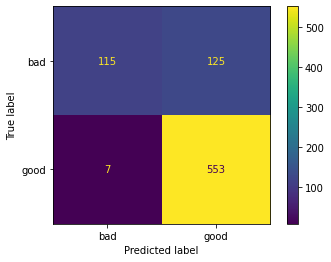

              precision    recall  f1-score   support

         bad       0.94      0.48      0.64       240
        good       0.82      0.99      0.89       560

    accuracy                           0.83       800
   macro avg       0.88      0.73      0.76       800
weighted avg       0.85      0.83      0.82       800


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


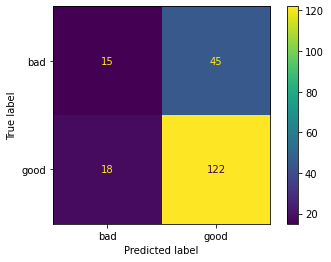

              precision    recall  f1-score   support

         bad       0.45      0.25      0.32        60
        good       0.73      0.87      0.79       140

    accuracy                           0.69       200
   macro avg       0.59      0.56      0.56       200
weighted avg       0.65      0.69      0.65       200



In [15]:
pipe = Pipeline([("gb", GradientBoostingClassifier(random_state=42))])

pipe.fit(X_train, y_train)

_ = clf_metrics_train_test(pipe, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="bad")

Mas, agora sabemos como usar todas as features!

In [3]:
def pipe_pre_process_german(drop_not_features=["Risk"], col_target="Risk",
                             inputer_num_strategy="mean",
                             encoding="ordinal"):
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    '''
    
    df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

    X = df.drop(columns=drop_not_features)
    y = df[col_target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy=inputer_num_strategy)),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

Vamos construir um modelo com os hiperparâmetros default (mas `learning_rate=0.1`)

In [4]:
X_train, X_test, y_train, y_test, pre_processador = pipe_pre_process_german(drop_not_features=["Risk"], col_target="Risk",
                                                                             inputer_num_strategy="mean",
                                                                             encoding="ordinal")

In [18]:
pre_processador

ColumnTransformer(transformers=[('transf_num',
                                 Pipeline(steps=[('input_num', SimpleImputer()),
                                                 ('std', StandardScaler())]),
                                 ['Age', 'Job', 'Credit amount', 'Duration']),
                                ('transf_cat',
                                 Pipeline(steps=[('input_cat',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Sex', 'Housing', 'Saving accounts',
                                  'Checking account', 'Purpose'])])

Métricas de avaliação de treino - com cutoff = 0.50


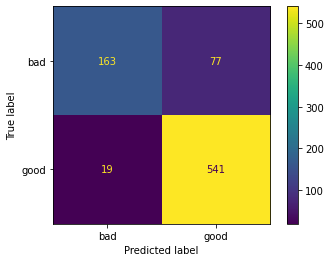

              precision    recall  f1-score   support

         bad       0.90      0.68      0.77       240
        good       0.88      0.97      0.92       560

    accuracy                           0.88       800
   macro avg       0.89      0.82      0.85       800
weighted avg       0.88      0.88      0.87       800


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


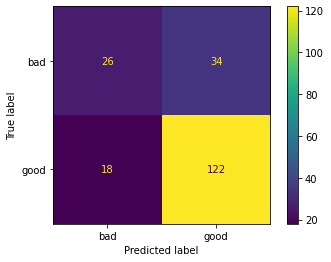

              precision    recall  f1-score   support

         bad       0.59      0.43      0.50        60
        good       0.78      0.87      0.82       140

    accuracy                           0.74       200
   macro avg       0.69      0.65      0.66       200
weighted avg       0.72      0.74      0.73       200



In [19]:
from sklearn.ensemble import GradientBoostingClassifier

pipe = Pipeline([("pp", pre_processador), 
                 ("gb", GradientBoostingClassifier(random_state=42))])

pipe.fit(X_train, y_train)

_ = clf_metrics_train_test(pipe, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="bad")

Nada mal. Vamos ver se conseguimos melhorar com o Grid Search:

In [23]:
np.arange(100, 600, 100)

array([100, 200, 300, 400, 500])

In [24]:
pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(random_state=42))])

params_grid = {"gb__loss" : ["log_loss", "exponential"],
               "gb__n_estimators" : np.arange(100, 600, 100),
               "gb__max_depth" : [1, 2]}

splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

grid_gb = GridSearchCV(pipe,
                       params_grid, 
                       cv=splitter,
                       scoring="f1_weighted",
                       verbose=10,
                       n_jobs=-1)

grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Job',
                                                                          'Credit '
                                                                          'amount',
                                                                          'Duration']),
                                                                        ('transf_cat',
                                                                         Pipeline(steps=[('input_cat',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strat...
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Sex',
                                                                          'Housing',
                                                                          'Saving '
                                                                          'accounts',
                                                                          'Checking '
                                                                          'account',
                                                                          'Purpose'])])),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gb__loss': ['log_loss', 'exponential'],
                         'gb__max_depth': [1, 2],
                         'gb__n_estimators': array([100, 200, 300, 400, 500])},
             scoring='f1_weighted', verbose=10)

In [25]:
grid_gb.best_params_

{'gb__loss': 'exponential', 'gb__max_depth': 2, 'gb__n_estimators': 200}

In [26]:
grid_gb.best_score_

0.7299071543528693

Métricas de avaliação de treino - com cutoff = 0.50


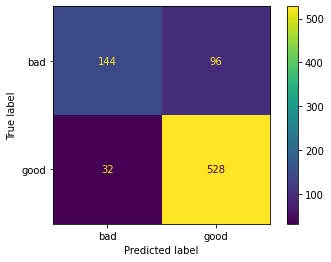

              precision    recall  f1-score   support

         bad       0.82      0.60      0.69       240
        good       0.85      0.94      0.89       560

    accuracy                           0.84       800
   macro avg       0.83      0.77      0.79       800
weighted avg       0.84      0.84      0.83       800


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


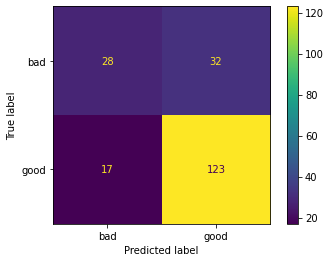

              precision    recall  f1-score   support

         bad       0.62      0.47      0.53        60
        good       0.79      0.88      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200



In [27]:
_ = clf_metrics_train_test(grid_gb, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="bad")

E que tal um random search?

Aqui, podemos aumentar bem o espaço de hiperparâmetros, e selecionar apenas algumas poucas combinações (mas de maneira totalmente aleatória!)

In [31]:
np.arange(10, 1001, 1)

array([  10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48,   49,   50,   51,   52,   53,
         54,   55,   56,   57,   58,   59,   60,   61,   62,   63,   64,
         65,   66,   67,   68,   69,   70,   71,   72,   73,   74,   75,
         76,   77,   78,   79,   80,   81,   82,   83,   84,   85,   86,
         87,   88,   89,   90,   91,   92,   93,   94,   95,   96,   97,
         98,   99,  100,  101,  102,  103,  104,  105,  106,  107,  108,
        109,  110,  111,  112,  113,  114,  115,  116,  117,  118,  119,
        120,  121,  122,  123,  124,  125,  126,  127,  128,  129,  130,
        131,  132,  133,  134,  135,  136,  137,  138,  139,  140,  141,
        142,  143,  144,  145,  146,  147,  148,  149,  150,  151,  152,
        153,  154,  155,  156,  157,  158,  159,  1

In [34]:
np.arange(1, 51, 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [30]:
pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(random_state=42))])

params_distros = {"gb__loss" : ["log_loss", "exponential"],
                  "gb__n_estimators" : np.arange(10, 1001, 1),
                  "gb__max_depth" : np.arange(1, 51, 1),
                  "gb__learning_rate" : scipy.stats.loguniform(1e-6, 1e+1)}

splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

rand_gb = RandomizedSearchCV(pipe,
                             params_distros,
                             n_iter=20,
                             cv=splitter,
                             scoring="f1_weighted",
                             verbose=10,
                             n_jobs=-1,
                             random_state=42)

rand_gb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('pp',
                                              ColumnTransformer(transformers=[('transf_num',
                                                                               Pipeline(steps=[('input_num',
                                                                                                SimpleImputer()),
                                                                                               ('std',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Job',
                                                                                'Credit '
                                                                                'amount',
                                                                                'Duration']),
                                                                              ('transf_cat',
                                                                               Pipeline(steps=[('input_cat',
                                                                                                SimpleImputer(fill_value='unknown'...
        923,  924,  925,  926,  927,  928,  929,  930,  931,  932,  933,
        934,  935,  936,  937,  938,  939,  940,  941,  942,  943,  944,
        945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,
        956,  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,
        967,  968,  969,  970,  971,  972,  973,  974,  975,  976,  977,
        978,  979,  980,  981,  982,  983,  984,  985,  986,  987,  988,
        989,  990,  991,  992,  993,  994,  995,  996,  997,  998,  999,
       1000])},
                   random_state=42, scoring='f1_weighted', verbose=10)

In [35]:
rand_gb.best_params_

{'gb__learning_rate': 0.12328322054506936,
 'gb__loss': 'log_loss',
 'gb__max_depth': 8,
 'gb__n_estimators': 471}

Métricas de avaliação de treino - com cutoff = 0.50


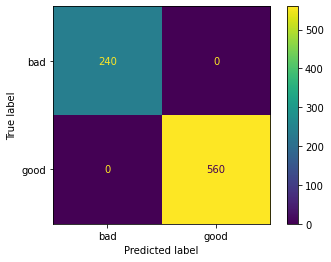

              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       240
        good       1.00      1.00      1.00       560

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


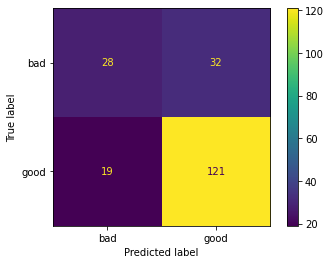

              precision    recall  f1-score   support

         bad       0.60      0.47      0.52        60
        good       0.79      0.86      0.83       140

    accuracy                           0.74       200
   macro avg       0.69      0.67      0.67       200
weighted avg       0.73      0.74      0.74       200



In [37]:
_ = clf_metrics_train_test(rand_gb, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="bad")

Resultado legal, melhor que o modelo sem busca de hiperparâmetros, mas tivemos um modelo claramente overfitado, o que muito provavelmente se deve ao `max_depth`: árvores profundas tendem a ser modelos overfitados! E, sobretudo para boosting, árvores profundas não é uma boa ideia. Por isso é importante que sempre tenhamos cuidado na definição do espaço de hiperparâmetros: nem sempre é uma boa ideia deixá-lo tão grande, sobretudo quando fazemos poucas amostras com o random search, como foi o caso.

A boa notícia é que a otimização bayesiana muda este cenário! Vamos então ver a otimização Bayesiana em ação na prática!

Como dissemos anterioremente, vamos utilizar a biblioteca `skopt`. 

Em particular, a classe que vamos utilizar é a [BayesSearchCV](http://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV), que é super parecida com as classes que conhecemos do sklearn (grid e random search)!

In [5]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [6]:
pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(random_state=42))])

params_distros = {"gb__loss" : Categorical(["log_loss", "exponential"]),
                  "gb__n_estimators" : Integer(50, 1000, "uniform"),
                  "gb__max_depth" : Integer(1, 50, "uniform"),
                  "gb__learning_rate" : Real(1e-6, 1e+1, "log-uniform")}

splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

bayes_gb = BayesSearchCV(pipe,
                         params_distros,
                         n_iter=20,
                         cv=splitter,
                         scoring="f1_weighted",
                         verbose=10,
                         n_jobs=-1,
                         random_state=42)

bayes_gb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('pp',
                                         ColumnTransformer(transformers=[('transf_num',
                                                                          Pipeline(steps=[('input_num',
                                                                                           SimpleImputer()),
                                                                                          ('std',
                                                                                           StandardScaler())]),
                                                                          ['Age',
                                                                           'Job',
                                                                           'Credit '
                                                                           'amount',
                                                                           'Duration']),
                                                                         ('transf_cat',
                                                                          Pipeline(steps=[('input_cat',
                                                                                           SimpleImputer(fill_value='unknown',
                                                                                                         stra...
              n_iter=20, n_jobs=-1, random_state=42, scoring='f1_weighted',
              search_spaces={'gb__learning_rate': Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
                             'gb__loss': Categorical(categories=('log_loss', 'exponential'), prior=None),
                             'gb__max_depth': Integer(low=1, high=50, prior='uniform', transform='normalize'),
                             'gb__n_estimators': Integer(low=50, high=1000, prior='uniform', transform='normalize')},
              verbose=10)

In [7]:
bayes_gb.best_params_

OrderedDict([('gb__learning_rate', 0.1740237291083292),
             ('gb__loss', 'log_loss'),
             ('gb__max_depth', 1),
             ('gb__n_estimators', 808)])

Métricas de avaliação de treino - com cutoff = 0.50


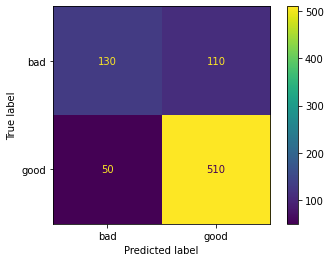

              precision    recall  f1-score   support

         bad       0.72      0.54      0.62       240
        good       0.82      0.91      0.86       560

    accuracy                           0.80       800
   macro avg       0.77      0.73      0.74       800
weighted avg       0.79      0.80      0.79       800


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


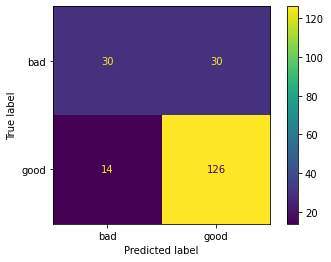

              precision    recall  f1-score   support

         bad       0.68      0.50      0.58        60
        good       0.81      0.90      0.85       140

    accuracy                           0.78       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.77      0.78      0.77       200



In [8]:
_ = clf_metrics_train_test(bayes_gb, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="bad")

Conseguimos melhorar ainda mais nosso modelo, e com o mesmo número de iterações! 

Esse é o poder da otimização Bayesiana!

___________

## 3) Ferramentas de visualização da skopt

Além da classe que nos permite fazer a otimização bayesiana de modo totalmente integrada e similar ao sklearn, a `skopt` disponibiliza também ferramentas muito interessantes para a visualização do processo de otimização de hiperparâmetros!

Vamos conhecer algumas destas ferramentas!

### Gráfico de convergência 

Com o método [plot_convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence), visualizar a evolução da métrica de avaliação desejada em função do número de iterações.

Lembre-se que o valor da métrica de avaliação nada mais é que $F(x)$, o valor da função objetivo avaliada a cada combinação de hiperparâmetros $x$ que é amostrada em cada iteração!


In [15]:
pd.DataFrame(bayes_gb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gb__learning_rate,param_gb__loss,param_gb__max_depth,param_gb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.547459,1.464219,0.034680,0.012640,0.000743,log_loss,47,350,"{'gb__learning_rate': 0.0007425534359037013, '...",0.576471,0.576471,0.576471,0.576471,0.576471,0.576471,0.000000,16
1,2.478669,0.582760,0.026283,0.010948,0.727308,log_loss,16,954,"{'gb__learning_rate': 0.7273082081096716, 'gb_...",0.582470,0.698518,0.581651,0.681159,0.696110,0.647982,0.054153,11
2,4.571165,0.839971,0.025186,0.004830,0.0013,log_loss,6,462,"{'gb__learning_rate': 0.0012996535162010368, '...",0.623480,0.703125,0.630769,0.623392,0.651870,0.646527,0.030155,12
3,2.273045,0.569922,0.028385,0.013655,0.486152,exponential,30,813,"{'gb__learning_rate': 0.4861518228524981, 'gb_...",0.693732,0.680764,0.586835,0.663266,0.658124,0.656544,0.037085,6
4,1.992512,0.505691,0.024709,0.007643,0.395252,exponential,27,730,"{'gb__learning_rate': 0.395252013727049, 'gb__...",0.693732,0.680764,0.576448,0.665831,0.647825,0.652920,0.041186,8
5,5.629309,1.242735,0.036792,0.008146,0.137466,log_loss,9,229,"{'gb__learning_rate': 0.1374662627789092, 'gb_...",0.732174,0.775610,0.643615,0.659189,0.716974,0.705512,0.048442,3
6,22.212528,3.759769,0.042575,0.014751,0.020872,log_loss,19,881,"{'gb__learning_rate': 0.020871588778809444, 'g...",0.633927,0.692138,0.599168,0.670919,0.658124,0.650855,0.031993,10
7,24.786567,6.631021,0.053368,0.016383,0.006365,log_loss,25,846,"{'gb__learning_rate': 0.006365338060906856, 'g...",0.693732,0.697802,0.589851,0.676009,0.668406,0.665160,0.039196,4
8,0.646789,0.043433,0.023182,0.010902,4.879169,log_loss,44,445,"{'gb__learning_rate': 4.8791694844275515, 'gb_...",0.700465,0.669802,0.581651,0.655205,0.662500,0.653925,0.039285,7
9,7.217781,1.591163,0.032019,0.014098,0.000001,log_loss,37,292,"{'gb__learning_rate': 1.0602594470835007e-06, ...",0.576471,0.576471,0.576471,0.576471,0.576471,0.576471,0.000000,16


In [13]:
bayes_gb.best_params_

OrderedDict([('gb__learning_rate', 0.1740237291083292),
             ('gb__loss', 'log_loss'),
             ('gb__max_depth', 1),
             ('gb__n_estimators', 808)])

In [21]:
bayes_gb.optimizer_results_[0]

          fun: -0.7187638686039872
    func_vals: array([-0.57647059, -0.64798168, -0.64652711, -0.65654402, -0.65292004,
       -0.70551241, -0.65085515, -0.66516   , -0.65392468, -0.57647059,
       -0.59811858, -0.63301717, -0.57647059, -0.64629715, -0.71620273,
       -0.71876387, -0.65268023, -0.57647059, -0.54103808, -0.65657512])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_opti

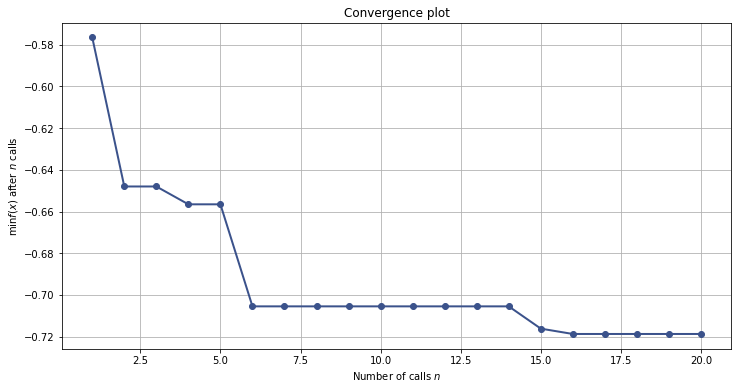

In [27]:
from skopt.plots import plot_convergence

plt.figure(figsize=(12, 6))
plot_convergence(bayes_gb.optimizer_results_[0]);

O efeito do uso do princípio Bayesiano é claro: ao invés de caminharmos aleatoriamente e sem direcionamento no espaço de hiperparâmetros (que é o que o random search faz), com a opt bayesiana vemos que, a cada iteração, o valor da função objetivo é sistematicamente reduzido, o que é um reflexo do direcionamento bayesiano que temos na busca por hiperparâmetros!

### Gráficos de Dependência Parcial

Uma outra visualização interessante é a de [dependência parcial](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html#skopt.plots.plot_objective), que mostra o efeito marginal que cada hiperparâmetro tem no resultado previsto de um modelo, marginalizando os valores dos demais hiperparâmetros de entrada.

O método `plot_objective()` plota uma a diagonal inferior de uma matriz com os chamados **gráficos de dependência parcial** da função objetivo, ou seja, mostra a influência de cada dimensão do espaço de busca (espaço de hiperparâmetros) na função objetivo. Para estimar a função objetivo ele usa o último modelo ajustado.

Na diagonal temos o efeito de uma única dimensão na função objetivo, enquanto os gráficos abaixo da diagonal mostram o efeito na função objetivo ao variar duas dimensões.

A Dependência Parcial é calculada pela média do valor objetivo para um número de amostras aleatórias no espaço de busca, mantendo uma ou duas dimensões fixas em intervalos regulares. Isso calcula a média do efeito de variar as outras dimensões e mostra a influência de uma ou duas dimensões na função objetivo.

Os pequenos pontos pretos são os pontos que foram amostrados durante a otimização, enquanto a estrela vermelha indica o melhor valor observado (isto é, que minimizou (conjuntamente) a função objetivo).

In [25]:
bayes_gb.best_params_

OrderedDict([('gb__learning_rate', 0.1740237291083292),
             ('gb__loss', 'log_loss'),
             ('gb__max_depth', 1),
             ('gb__n_estimators', 808)])

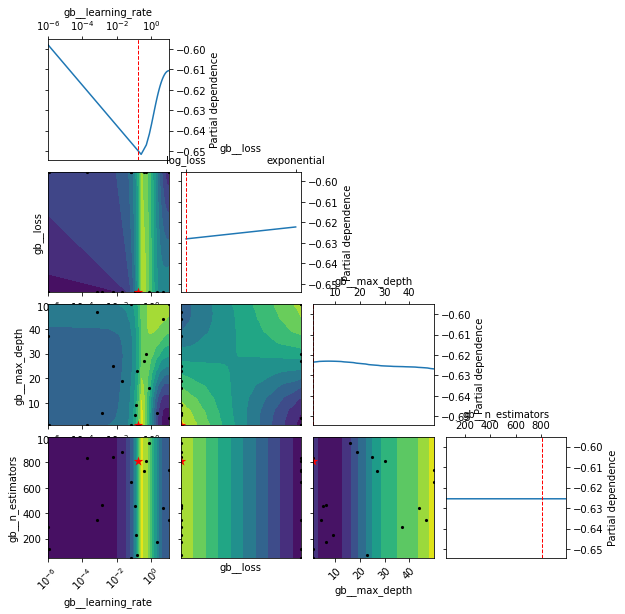

In [24]:
from skopt.plots import plot_objective

plot_objective(bayes_gb.optimizer_results_[0]);

### Plot de avaliações

Outro plot interessante é o [plot de avaliações](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_evaluations.html#skopt.plots.plot_evaluations), com o método `plot_evaluations`, que na diagonal mostra histogramas dos pontos que foram amostrados para cada uma das dimensões do espaço de busca, e na diagonal inferior mostra um gráfico de dispersão (scatter) bidimensional de todos os pontos no qual a ordem em que os pontos foram avaliados está codificada na cor de cada ponto. Cores mais escuras/roxas correspondem a amostras anteriores e cores mais claras/amarelas correspondem a amostras posteriores. A estrela em vermelho mostra a localização do mínimo encontrado pelo processo de otimização.

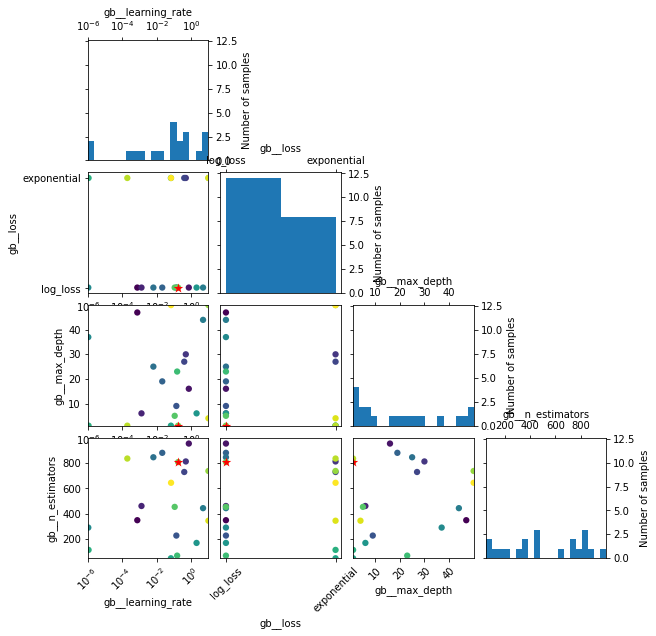

In [26]:
from skopt.plots import plot_evaluations

plot_evaluations(bayes_gb.optimizer_results_[0]);

___________

Depois de termos visto a otimização bayesiana na prática, e seu enorme poder, podemos nos enganhar em achar que esta técnica é suprema, e que tudo o que aprendemos antes é dispensável. Por isso, é importante mencionar algumas últimas palavras sobre este método, em particular no que diz respeito às suas limitações.

### Limitações da otimização bayesiana

- A principal limitação da otimização Bayesiana com Processos Gaussianos é a eficiência. À medida que a dimensionalidade aumenta, mais pontos precisam ser avaliados. Infelizmente, o custo da inferência exata no processo gaussiano escala como $O(n^3)$ onde n é o número de pontos de dados.

- Não é facilmente paralelizável como o GridSearch e o RandomSearch, o que faz sentido, dada a natureza bayesiana do método. Apesar de termos utilizado o n_jobs, os ganhos de paralelização que temos são marginais.

Na otimização bayesiana, gastamos um pouco mais de tempo selecionando os próximos hiperparâmetros (utilizando o surrogate e a função de seleção), mas fazemos menos chamadas na função objetivo (que envolve o treinamento e avaliação do modelo, e, por isso, é um procedimento custoso!). Na prática, o tempo gasto selecionando os próximos hiperparâmetros é muito menor quando comparado com o tempo gasto nas avaliações da função objetivo (treinamento e avaliação do modelo).

Sempre teremos um trade-off entre garantir a melhor combinação de hiperparâmetros e o custo de encontrá-la. É nosso dever saber balancear bem este trade-off.

E, apesar destas técnicas avançadas, lembre-se que o que realmente costuma dar resultados impactantes em modelos é a utilização de bons dados, boas features. Assim, para além das técnicas avançadas que aprendemos, empregar grande parte do tempo que temos disponível em uma boa análise exploratória e criação de features tende a ser algo muito recompensador em termos de entrega de performance!

___________

### Bibliografia e Aprofundamento

Para quem quiser se aprofundar um pouco mais na otimização bayesiana, tenho as seguintes recomendações:

- [Explicação simples e didática](https://pt.quora.com/Como-funciona-a-otimiza%C3%A7%C3%A3o-bayesiana)
- [Comparação entre vários pacotes e métodos de otimização bayesiana](https://medium.com/@gerbentempelman/comparing-hyperparameter-optimization-frameworks-in-python-a-conceptual-and-pragmatic-approach-24d9baa1cc69)
- [Um pouco mais matemático](https://medium.com/criteo-engineering/hyper-parameter-optimization-algorithms-2fe447525903)
- [Vídeo mostrando o funcionamento](https://gfycat.com/legalanyantelopegroundsquirrel)
- [Gifs mostrando a difetença de uma função de aquisição exploitative e explorative](https://www.andreaamico.eu/reinforcement-learning/2019/05/08/bayesian_opt.html)
- [O que é Otimização Bayesiana](https://machinelearningmastery.com/what-is-bayesian-optimization/)